In [1]:
# This notebook checks MNE functions for ECG and EOG detection
# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import configparser

from main_meg_qc import initial_stuff


In [2]:
n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads, mags, grads, filtered_d, filtered_d_resamp, raw_cropped, raw=initial_stuff(sid=1)

config = configparser.ConfigParser()
config.read('settings.ini')
default_section = config['DEFAULT']
duration = default_section.getint('duration') 

Opening raw data file ../data/ck06an19_vp13/190521/vp13_block1-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 2974000 ... 4443999 =   2974.000 ...  4443.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/../data/ck06an19_vp13/190521/vp13_block1-3.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_

/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:17: RuntimeWarning: This filename (../data/ck06an19_vp13/190521/vp13_block1-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(data_file)


Reading 0 ... 60000  =      0.000 ...    60.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 100.00 Hz: -6.02, -6.02 dB

No events with set minimum duration were found using all stimulus channels. No epoching can be done.


In [4]:
# Find channel names:

picks_ECG_EOG = mne.pick_types(filtered_d.info, ecg=True, eog=True)
if picks_ECG_EOG.size == 0:
    print('No channels for ECG, EOG present is this data set')
else:
    ECG_channel_name = raw.info['chs'][picks_ECG_EOG[0]]['ch_name']
    EOG_channel_name = [raw.info['chs'][picks_ECG_EOG[1]]['ch_name'], raw.info['chs'][picks_ECG_EOG[2]]['ch_name']]
    print(ECG_channel_name)
    print(EOG_channel_name)



ECG001
['EOG002', 'EOG003']


In [5]:

#Find ECG events by localizing the R wave peaks.
#IT DOES FIND ECG EVENTS, even when no dedicated channel is present. Reconstructs from magnetometers.

ecg_events, ch_ecg, average_pulse, ecg=mne.preprocessing.find_ecg_events(filtered_d, return_ecg=True, verbose=True)
# can explicitely give ECG channel here but not nessesary. MNE can detect it automatically.

# ecg_events array
# The events corresponding to the peaks of the R waves.
# ch_ecg - str - Name of channel used.

# average_pulse float
# The estimated average pulse. If no ECG events could be found, this will be zero.

# ecg array | None
# The ECG data of the synthesized ECG channel, if any. This will only be returned if return_ecg=True was passed.

# HOW TO FIND THE TIME OF EVENTS:
# https://github.com/mne-tools/mne-python/issues/5201
ecg_events_times  = (ecg_events[:, 0] - raw.first_samp) / raw.info['sfreq']

#https://mne.tools/stable/glossary.html#term-first_samp
#The first_samp attribute of Raw objects is an integer representing the number of time samples that passed between 
# the onset of the hardware acquisition system and the time when data recording started. This approach to sample 
# numbering is a peculiarity of VectorView MEG systems, but for consistency it is present in all Raw objects regardless 
# of the source of the data. In other words, first_samp will be 0 in Raw objects loaded from non-VectorView data files.


#print('ECG events: \n', ecg_events) 
print('Channels used to detect ECG: ', ch_ecg) 
print('Average pulse: ', average_pulse) 
print('ECG data of the synthesized ECG channel: \n',ecg)

print('Times of ECG events: \n', ecg_events_times)

Using channel ECG001 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 61 (average pulse 60 / min.)
Channels used to detect ECG:  0
Average pulse:  60.998983350277506
ECG data of the synthesized ECG channel: 
 [[-4.65868121e-20 -5.05906485e-07 -1.00834988e-06 ... -4.06988560e-07
  -2.40983634e-07 -7.79270311e-20]]
Times of ECG events: 
 [ 0.596  1.572  2.532  3.462  4.445  5.466  6.416  7.409  8.417  9.39
 10.349 11.369 12.417 13.431 14.347 15.31  16.3   17.248 18.224 19.25
 20.248 21.217 22.203 23.1

In [6]:
len(ecg_events)

61

In [7]:
#Plot the found ECG events on one of the channels:

selected_mags = [item[1] for item in mags]
selected_grads = [item[1] for item in grads]
data_mags, _ = filtered_d[selected_mags, :]  
data_grads, _ = filtered_d[selected_grads, :]  

dt=duration/len(data_mags[30]) #samplig frequency (resampled data)

#ecg_events_times_ind=np.array(ecg_events_times*raw.info['sfreq']/1000).astype(int)

#t=np.arange(0, duration, dt) 
t=np.arange(0, duration, 1/raw.info['sfreq'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=data_mags[2], name='data'));
#fig.add_vline(x=ecg_events_times, line_width=1, line_dash="dash", line_color="green")
for ecg in ecg_events_times:
    fig.add_vline(x=ecg, line_width=1, line_color="green")

fig.update_layout(
    title={
    'text': "ECG events on data of 1 magnetometer",
    'y':0.85,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Time in sec",
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'e'))

fig.show()

Using channel ECG001 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 61 (average pulse 60 / min.)
Not setting metadata
61 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
Using data from preloaded Raw for 61 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
61 matching events found
No base

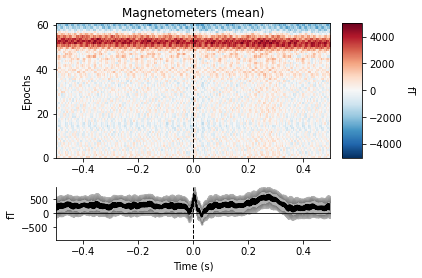

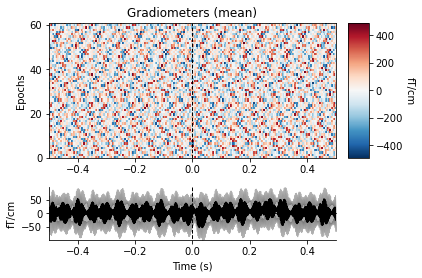

[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

In [11]:
#THIS FUNCTION CREATES EPOCHS ON BASE OF ECG EVENTS. 
# It calls find_ecg_events internally, so no need to run previous cell for it.

%matplotlib inline

ecg_epochs = mne.preprocessing.create_ecg_epochs(raw_cropped)
ecg_epochs.plot_image(combine='mean')

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 8)
8 projection items activated
SSP projectors applied...


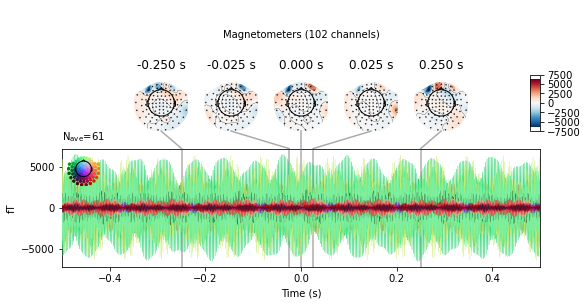

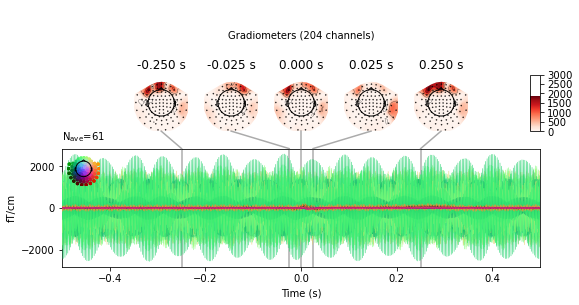

[<Figure size 576x302.4 with 9 Axes>, <Figure size 576x302.4 with 9 Axes>]

In [9]:
# Here I simply repeat the steps from mne tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#averaging the ECG epochs together:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))

avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])
# I guess 0 represents the actual ECG event and all around - the epoch and how the ECG signal developes during 
# the ECG epoch on everage over all channels?


In [12]:
# How to do correlations of the shape of mean ecg with the data. To see which channels are contaminated most.
# Jochem describedd in the meeting:
# - average epochs around ECG events channel wise -> vector 
# - divide vector by norm (square root of dot product of vector with itself) --> vector of length 1 (reference heartbeat vector)
# - dot product between epoch and norm vector
# (look up in the Statistical Learning course again)


# - 1. average epochs around ECG events channel wise -> vector 
ecg_evoked = mne.preprocessing.create_ecg_epochs(raw_cropped).average()
print(ecg_evoked.data[0, :]) # for example: averaged ECG event (evoked) data of first channel, all timepoints

# Project vector of average ECG artifact onto epoch vector:
# - divide vector by norm (square root of dot product of vector with itself) --> vector of length 1 (reference heartbeat vector)
# - dot product between epoch and norm vector
#  
v=ecg_evoked.data[0, :]

df_m = epochs_mags[3, 0].to_data_frame()
ep= epochs_mags

# General VECTOR PROJECTION technique: https://www.geeksforgeeks.org/vector-projection-using-python/
v_to_ep_proj = (np.dot(ep, v)/np.dot(v, v))*v

# But according to Jochems paper, need to project epoch (data+ noise) onto the noise (ecg_evoked), not the other way around? 
# To find the noise component in the epoch.


# _____________

# Actually, found mne.preprocessing.compute_proj_ecg which seemst to be already doing all the described steps. Is this what we need?
#
# "Compute SSP (signal-space projection) vectors for ECG artifacts.

# This function will:

# Filter the ECG data channel.

# Find ECG R wave peaks using mne.preprocessing.find_ecg_events().

# Filter the raw data.

# Create Epochs around the R wave peaks, capturing the heartbeats.

# Optionally average the Epochs to produce an Evoked if average=True was passed (default).

# Calculate SSP projection vectors on that data to capture the artifacts.

# Evoked objects typically store EEG or MEG signals that have been averaged over multiple epochs,

# 

# _______
# Evoked: shape (n_channels, n_times)
# Epoch: shape (n_epochs, n_channels, n_times)


Using channel ECG001 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 61 (average pulse 60 / min.)
Not setting metadata
61 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
Using data from preloaded Raw for 61 events and 1001 original time points ...
0 bad epochs dropped
[ 3.50698565e-13  2.56130969e-13  5.26900369e-14 ...  1.80194104e-13
 -3.71367032e-14  2.50683143e-13]


TypeError: 'NoneType' object is not subscriptable

In [13]:
df_m = epochs_mags[3].to_data_frame()

df_m

TypeError: 'NoneType' object is not subscriptable

In [14]:
# Find EOG events:
# https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html

eog_events=mne.preprocessing.find_eog_events(raw, thresh=None, ch_name=None)
# threshfloat | None
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying 
# peak-finding algorithm. Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# UNLIKE ECG, CAN NOT RECONSTRUCT EOG EVENTS IF NO DEDICATED CHANNEL IS PRESENT. SO EPOCHS CANT BE CREATED EITHER
# AS EOG channels it needs either: with type eog or ordinary EEG channel that was placed close to the eyes, like Fp1 or Fp2

# But we dont have any of these

# Another related function, but again needs EOG channel or other channels where EOG should be extracted from:
# https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.find_bads_eog


Using EOG channels: EOG002, EOG003
EOG channel index for this subject is: [1 2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 908 significant peaks
Number of EOG events detected: 908


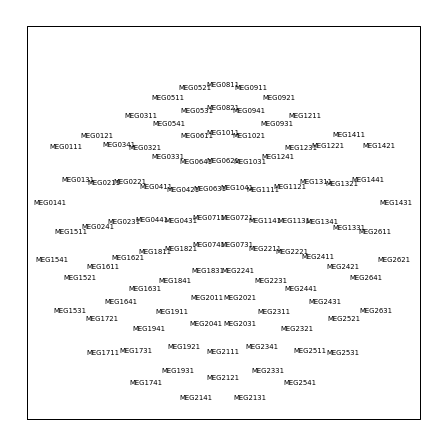

Using EOG channels: MEG0521, MEG0911, MEG0511, MEG0921
EOG channel index for this subject is: [ 59  62 101 104]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 17 significant peaks
Number of EOG events detected: 17


In [ ]:
# RUN THIS CELL ONLY IF YOU DONT HAVE EOG CHANNELS

# "If you don’t have an EOG channel, find_bads_eog has a ch_name parameter that you can use as a proxy for EOG. 
# You can use a single channel, or create a bipolar reference from frontal EEG sensors and use that as virtual EOG channel. 
# This carries a risk however: you must hope that the frontal EEG channels only reflect EOG and not brain dynamics in 
# the prefrontal cortex (or you must not care about those prefrontal signals)."

# So here I plot the magnetometers layout, choose 4 magnetometers near the eyes and try to extract eyeblinks from there

# What is better mags or grads for eyeblinks reconstruction? Or both?

%matplotlib inline

layout_from_raw=mne.channels.find_layout(raw.info, ch_type='mag')
fig=layout_from_raw.plot()

eog_events=mne.preprocessing.find_eog_events(raw, thresh=1e-8, ch_name=['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921'])
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying peak-finding algorithm. 
# Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# Detected only 3 EOG events in th entire 1h dataset if threshold is set to defailt: thresh=None
# -> Try to adjust threshold or, maybe it just doesnt really work.
# -> Above: set the threshold to 1e-8, detects 17 eyeblink events - also too little. But I got no idea what threshold value is optimal.

#%% Now want to see the data for these 4 channels I chose for eyeblinks:
chans = ['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921']

#I only know how to plot channels by the idexes, not by names, so have to extract indexes first:
EOG_ch=[]
for c in chans:
    ch=[item for item in mags if c in item]
    EOG_ch.append(ch[0][1])

%matplotlib qt
raw.plot(order=EOG_ch, start=12, duration=4) #plot here only a part of channel."

#Lets discuss if these look like eyeblink!

In [15]:
# Extract EOG epochs:

eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
#This function will internally call the find_eog_events again (no need to run previous cell). So I pass the chosen mag channels near the eyes again.


eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint()

#Looks definitely not the same as in preprocessing tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#Should discuss what do we see here.

# Also - wan to plot data of these 4 channels but I again cant find hot to plot patticukar channels.


Using EOG channels: EOG002, EOG003
EOG channel index for this subject is: [1 2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 908 significant peaks
Number of EOG events detected: 908
Not setting metadata
908 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 8)
Loading data for 908 events and 1001 original time points ...
0 bad epochs dropped
Not setting

: 

: 

In [ ]:
# Next, there is ICA used for ECG and EOG artifacts repair.
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

# Functions ica_find_ecg_events and ica_find_eog_events - are not working independently, 
# they need to functions above to run first





In [ ]:
# found interesting function to fix stimulus artifacts: 
# https://mne.tools/stable/generated/mne.preprocessing.fix_stim_artifact.html